In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams
import numpy as np
from sklearn import preprocessing

import json
import glob
from natsort import natsorted
import pandas as pd

# import matplotlib.font_manager
# print([f.name for f in matplotlib.font_manager.fontManager.ttflist])


### データフレームに落とし込むための辞書を初期化

In [120]:
flnum = 9
dict = {'building':[],'floor':[],'pool_size':[],'batch':[], 'elv_size':[],'robonum':[],'roboalloc':[], 'comp_time':[], 'dloc_time':[]} #robo_f1_at, robo_f1_td, robo_f2_at,...., e_at, e_td
for i in range(1, flnum+1):
    dict['robo_f{}_mt'.format(str(i).zfill(2))] = []    # move time
    dict['robo_f{}_at'.format(str(i).zfill(2))] = []    # action time
    dict['robo_f{}_st'.format(str(i).zfill(2))] = []    # standby time
    dict['robo_f{}_td'.format(str(i).zfill(2))] = []    # travel distance
    
dict['robo_mean_mt'] = []    # mean move time
dict['robo_mean_at'] = []    # mean action time
dict['robo_mean_st'] = []    # mean standby time
dict['robo_mean_td'] = []    # mean travel distance

dict['elv_mt'] = []
dict['elv_td'] = []
print(dict.keys())


dict_keys(['building', 'floor', 'pool_size', 'batch', 'elv_size', 'robonum', 'roboalloc', 'comp_time', 'dloc_time', 'robo_f01_mt', 'robo_f01_at', 'robo_f01_st', 'robo_f01_td', 'robo_f02_mt', 'robo_f02_at', 'robo_f02_st', 'robo_f02_td', 'robo_f03_mt', 'robo_f03_at', 'robo_f03_st', 'robo_f03_td', 'robo_f04_mt', 'robo_f04_at', 'robo_f04_st', 'robo_f04_td', 'robo_f05_mt', 'robo_f05_at', 'robo_f05_st', 'robo_f05_td', 'robo_f06_mt', 'robo_f06_at', 'robo_f06_st', 'robo_f06_td', 'robo_f07_mt', 'robo_f07_at', 'robo_f07_st', 'robo_f07_td', 'robo_f08_mt', 'robo_f08_at', 'robo_f08_st', 'robo_f08_td', 'robo_f09_mt', 'robo_f09_at', 'robo_f09_st', 'robo_f09_td', 'robo_mean_mt', 'robo_mean_at', 'robo_mean_st', 'robo_mean_td', 'elv_mt', 'elv_td'])


## File load

In [121]:
n =0

for fl in [3, 6, 9]:
    for p in range(1,11):
        l_path = '../record/small_warehouse_e*/floor0{}/robonum0{}/P/pool0{}/*.json'.format(fl,str(fl*2).zfill(2), str(p**2).zfill(3))
        # print(glob.glob(l_path))
        l_files = natsorted(glob.glob(l_path))
        n+=len(l_files)
        # print(n)
        # print(file.split('/')[-1] lambda x: file in l_files)

        for l_file in l_files:
            # print(l_file.split('/')[2:])
            content = []
            with open(l_file) as f:
                content = json.load(f)
                dict['building'].append(content['config']['building_type'])
                dict['floor'].append(fl)
                dict['pool_size'].append(p**2)
                if 'batch'in content['input'].keys():
                    if content['input']['batch']:
                        if content['input']['batch'] > p**2*1.5*0.8:
                            dict['batch'].append((p**2*1.5*0.8//0.5+1)*0.5)
                        else:
                            dict['batch'].append(content['input']['batch'])
                    else:dict['batch'].append(((p**2)*1.5*0.8//0.5+1)*0.5)
                else:
                    # if p== 8.0:
                    #     print(((p**2)*1.5*0.8//0.5+1)*0.5)
                    dict['batch'].append(((p**2)*1.5*0.8//0.5+1)*0.5)
                    
                # elvsize = content['config']['floor1']['elevator']
                # dict['elv_size'].append(abs((elvsize[0]-elvsize[3])*(elvsize[1]-elvsize[4])))    
                elvsize = content['config']['floor1']['elevator']
                #abs(ea.pos[3]-ea.pos[0])-ea.mesh), abs(ea.pos[1]-ea.pos[4])-ea.mesh*2
                dict['elv_size'].append((abs(elvsize[3]-elvsize[0])-0.5)*(abs(elvsize[1]-elvsize[4])-0.5*2))
                dict['robonum'].append(sum(content['input']['robot_allocation']))
                dict['roboalloc'].append(str(content['input']['robot_allocation']))
                dict['comp_time'].append(float(content['output']['complete_time']))
                if 'deadloc_time' in content['output'].keys():
                    dict['dloc_time'].append(float(content['output']['deadloc_time']))
                else:
                    dict['dloc_time'].append(0)
                
                fl_robo = {}
                for i in range(1,flnum+1):
                    fl_robo[i] = {}
                    fl_robo[i]['mt'] = []
                    fl_robo[i]['at'] = []
                    fl_robo[i]['st'] = []
                    fl_robo[i]['td'] = []
                mean_mt = []
                mean_at = []
                mean_st = []
                mean_td = []
                for robo, info in content['info']['robot'].items():
                    # print(robo, info)
                    fl_robo[int(info['floor'])]['mt'].append(float(info['move_time']))
                    fl_robo[int(info['floor'])]['at'].append(float(info['action_time']))
                    fl_robo[int(info['floor'])]['st'].append(float(info['standby_time']))
                    fl_robo[int(info['floor'])]['td'].append(float(info['travel_distance']))
                    
                for j in range(1,flnum+1):
                    if fl_robo[j]['mt']:
                        # print(fl_robo[fl]['mt'])
                        dict['robo_f{}_mt'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['mt']) / len(fl_robo[j]['mt']),2 ))    # move time
                        dict['robo_f{}_at'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['at']) / len(fl_robo[j]['at']),2 ))    # action time
                        dict['robo_f{}_st'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['st']) / len(fl_robo[j]['st']),2 ))    # standby time
                        dict['robo_f{}_td'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['td']) / len(fl_robo[j]['td']),2 ))   # travel distance
                        mean_mt.append(round(sum(fl_robo[j]['mt']) / len(fl_robo[j]['mt']),2 ))
                        mean_at.append(round(sum(fl_robo[j]['at']) / len(fl_robo[j]['at']),2 ))
                        mean_st.append(round(sum(fl_robo[j]['st']) / len(fl_robo[j]['st']),2 ))
                        mean_td.append(round(sum(fl_robo[j]['td']) / len(fl_robo[j]['td']),2 )) 
                    else:
                        dict['robo_f{}_mt'.format(str(j).zfill(2))].append(None)    # move time
                        dict['robo_f{}_at'.format(str(j).zfill(2))].append(None)    # action time
                        dict['robo_f{}_st'.format(str(j).zfill(2))].append(None)    # standby time
                        dict['robo_f{}_td'.format(str(j).zfill(2))].append(None)  # travel distance
                dict['robo_mean_mt'].append(sum(mean_mt)/len(mean_mt))        # mean move time
                dict['robo_mean_at'].append(sum(mean_at)/len(mean_at))        # mean action time
                dict['robo_mean_st'].append(sum(mean_st)/len(mean_st))        # mean standby time
                dict['robo_mean_td'].append(sum(mean_td)/len(mean_td))        # mean travel distance
                
                for elv, info in content['info']['elevator'].items():
                    dict['elv_mt'].append(float(info['move_time']))
                    dict['elv_td'].append(float(info['travel_distance']))
            f.close()
# for k, v in dict.items():
#     print(k, len(v))
# print(dict)
print(n)
# pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_columns', 20)
df = pd.DataFrame(dict)
# df
# df[(df.dloc_time==0.0)&(df.floor==9)&(df.building=='small_warehouse')&(df.batch==59.0)]
# print(df.info())
# print(df[df.dloc_time != 0.0].info())



1663


In [122]:
df[df['floor']==3]

,building,floor,pool_size,batch,elv_size,robonum,roboalloc,comp_time,dloc_time,robo_f01_mt,...,robo_f09_mt,robo_f09_at,robo_f09_st,robo_f09_td,robo_mean_mt,robo_mean_at,robo_mean_st,robo_mean_td,elv_mt,elv_td
0,small_warehouse_e10,3,1,1.5,6.0,6,"[2, 2, 2]",13815.7,0.0,5705.50,...,NaN,NaN,NaN,NaN,3859.100000,3425.950000,6381.316667,2512.986667,523.8,1571.4
1,small_warehouse_e10,3,1,1.5,6.0,6,"[2, 2, 2]",13795.0,0.0,5714.75,...,NaN,NaN,NaN,NaN,3760.683333,3459.066667,6429.316667,2449.350000,542.0,1626.0
2,small_warehouse_e10,3,1,1.5,6.0,6,"[2, 2, 2]",14271.4,0.0,5857.30,...,NaN,NaN,NaN,NaN,3886.916667,3576.966667,6658.683333,2531.886667,539.2,1617.6
3,small_warehouse_e10,3,1,1.5,6.0,6,"[2, 2, 2]",13993.5,0.0,5672.25,...,NaN,NaN,NaN,NaN,3854.216667,3434.466667,6556.600000,2509.613333,518.0,1554.0
4,small_warehouse_e10,3,1,1.5,6.0,6,"[2, 2, 2]",14910.5,0.0,6100.50,...,NaN,NaN,NaN,NaN,3968.566667,3496.533333,7294.800000,2586.156667,557.3,1671.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,small_warehouse_e30,3,100,120.5,22.5,6,"[2, 2, 2]",10952.0,0.0,3188.85,...,NaN,NaN,NaN,NaN,2584.883333,3463.350000,4728.083333,1677.876667,416.8,1250.4
587,small_warehouse_e30,3,100,120.5,22.5,6,"[2, 2, 2]",11456.5,0.0,3421.65,...,NaN,NaN,NaN,NaN,2623.133333,3440.116667,5217.416667,1703.453333,447.6,1342.8
588,small_warehouse_e30,3,100,120.5,22.5,6,"[2, 2, 2]",11111.8,0.0,3138.15,...,NaN,NaN,NaN,NaN,2460.283333,3497.833333,4983.900000,1597.163333,359.7,1079.1
589,small_warehouse_e30,3,100,120.5,22.5,6,"[2, 2, 2]",10594.0,0.0,3143.95,...,NaN,NaN,NaN,NaN,2561.200000,3458.833333,4397.433333,1661.823333,449.4,1348.2


In [123]:
(73.5*0.8//0.5+1)*0.5
p=7
print(((p**2)*1.5*0.8//0.5+1)*0.5)
print((p**2)*1.5)
49*1.5

59.0
73.5


73.5

# グラフ可視化

## タスク処理時間での比較

### small warehouse

[ 6.  10.  14.  18.  22.5]


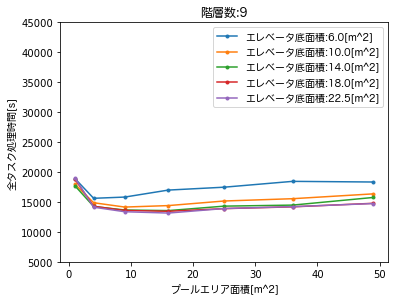

In [127]:
# small_df = df[(df.building=='small_warehouse') & (df.dloc_time==0.0)]
# #tmp = tar_df.groupby('pool_size').mean()
# #tmp.loc[:,'robo_f01_mt':'robo_f03_td'].plot(kind='bar')

# small_df.groupby('pool_size').mean()['comp_time'].plot(kind='bar')

small_df = df[(df.dloc_time==0.0)&(df.pool_size<50)]
small_df
print(small_df['elv_size'].unique())
fig = plt.figure(figsize=(20,15))
for fl in range(9,12,3):
    ax = fig.add_subplot(3,3,int(fl//3))
    for esize in small_df['elv_size'].unique():
        tmp_df = small_df[(small_df['floor']==fl) & (small_df['elv_size']==esize)&(small_df['batch']==(small_df['pool_size']*1.5*0.8//0.5+1)*0.5)]
        # print(tmp_df.info())
        # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        # print(tmp_df.var())
        t = tmp_df.groupby(['pool_size']).mean()['comp_time']
        #ax.plot([str(tmp) for tmp in t.index],t.values, label='elv size:{}'.format(esize))
        #ax.plot(list(t.index),t.values, label='elv size:{}'.format(esize))
        
        ax.plot(list(t.index),t.values, label='エレベータ底面積:{}[m^2]'.format(esize),marker=".")
        ax.legend(loc=0,prop={"family":"Hiragino Maru Gothic Pro"})  
        ax.set_title('階層数:{}'.format(fl),fontname="Hiragino Maru Gothic Pro")
        ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylabel('全タスク処理時間[s]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylim(5000,45000)

# sd = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))&(small_df['batch']==(small_df['pool_size']*0.8//0.5+1)*0.5)]
# sd

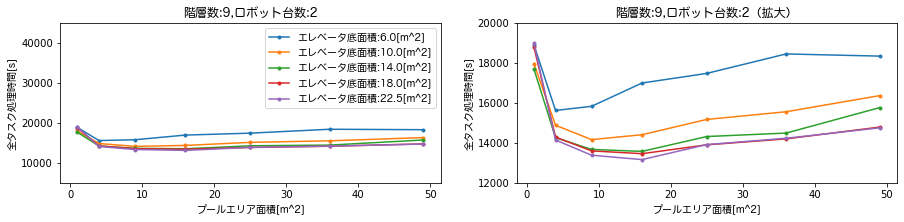

In [140]:
fig = plt.figure(figsize=(15,10))
fl =9
j=1
while j<=2:
        ax = fig.add_subplot(3,2,j)

        for esize in small_df['elv_size'].unique():
                tmp_df = small_df[(small_df['floor']==fl) & (small_df['elv_size']==esize)&(small_df['batch']==(small_df['pool_size']*1.5*0.8//0.5+1)*0.5)]
                # print(tmp_df.info())
                # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
                # print(tmp_df.var())
                t = tmp_df.groupby(['pool_size']).mean()['comp_time']
                #ax.plot([str(tmp) for tmp in t.index],t.values, label='elv size:{}'.format(esize))
                #ax.plot(list(t.index),t.values, label='elv size:{}'.format(esize))
                
                ax.plot(list(t.index),t.values, label='エレベータ底面積:{}[m^2]'.format(esize),marker=".")
                
                ax.set_xlabel('プールエリア面積[m^2]',fontname="Hiragino Maru Gothic Pro")
                ax.set_ylabel('全タスク処理時間[s]',fontname="Hiragino Maru Gothic Pro")
                if j==1:
                        ax.set_ylim(5000,45000)
                        ax.set_title('階層数:{},ロボット台数:2'.format(fl),fontname="Hiragino Maru Gothic Pro")
                        ax.legend(loc=0,prop={"family":"Hiragino Maru Gothic Pro"})
                else:
                        ax.set_title('階層数:{},ロボット台数:2（拡大）'.format(fl),fontname="Hiragino Maru Gothic Pro")
                        ax.set_ylim(12000,20000)
        j+=1

### ロボット台数ごとのロボット平均移動時間比較

### small warehouse

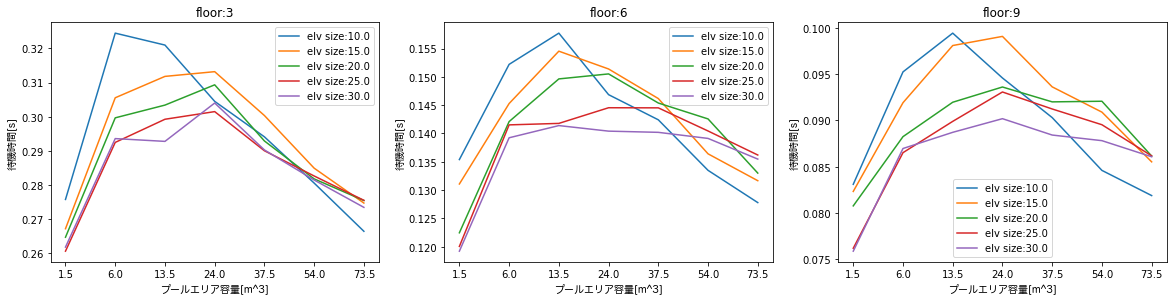

In [89]:

fig = plt.figure(figsize=(20,15))
for fl in range(3,12,3):
    ax = fig.add_subplot(3,3,int(fl//3))
    for esize in small_df['elv_size'].unique():
        tmp_df = small_df[(small_df['floor']==fl) & (small_df['elv_size']==esize)&(small_df['batch']==(small_df['pool_size']*0.8//0.5+1)*0.5)]
        # print(tmp_df.info())
        # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        # print(tmp_df.var())
        t = tmp_df.groupby(['pool_size']).mean()['robo_mean_mt'].div(tmp_df.groupby('pool_size').mean()['comp_time'])
        ax.plot([str(tmp) for tmp in t.index],t.values, label='elv size:{}'.format(esize))
        #ax.plot(list(t.index),t.values, label='elv size:{}'.format(esize))
        ax.legend(loc=0)  
        ax.set_title('floor:{}'.format(fl))
        ax.set_xlabel('プールエリア容量[m^3]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylabel('待機時間[s]',fontname="Hiragino Maru Gothic Pro")

## エレベータの比較

### small warehouse

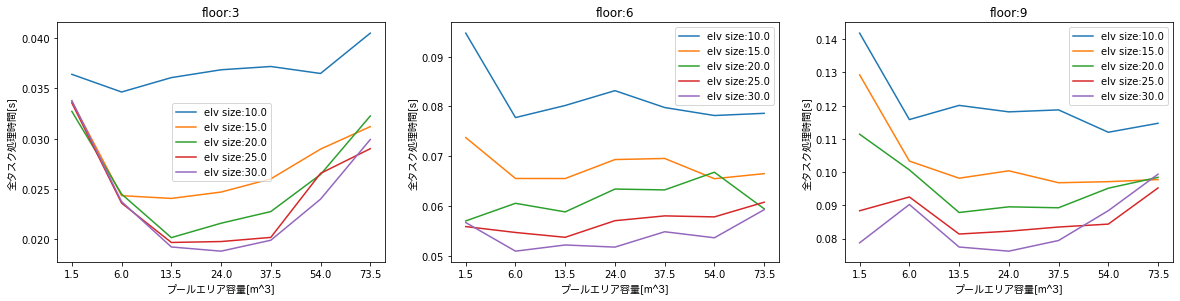

In [90]:
fig = plt.figure(figsize=(20,15))
for fl in range(3,12,3):
    ax = fig.add_subplot(3,3,int(fl//3))
    for esize in small_df['elv_size'].unique():
        tmp_df = small_df[(small_df['floor']==fl) & (small_df['elv_size']==esize)&(small_df['batch']==(small_df['pool_size']*0.8//0.5+1)*0.5)]
        # print(tmp_df.info())
        # ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        # print(tmp_df.var())
        t = tmp_df.groupby(['pool_size']).mean()['elv_mt'].div(tmp_df.groupby('pool_size').mean()['comp_time'])
        ax.plot([str(tmp) for tmp in t.index],t.values, label='elv size:{}'.format(esize))
        #ax.plot(list(t.index),t.values, label='elv size:{}'.format(esize))
        ax.legend(loc=0)  
        ax.set_title('floor:{}'.format(fl))
        ax.set_xlabel('プールエリア容量[m^3]',fontname="Hiragino Maru Gothic Pro")
        ax.set_ylabel('全タスク処理時間[s]',fontname="Hiragino Maru Gothic Pro")

## フロアごとのロボット稼働時間比較

### small warehouse

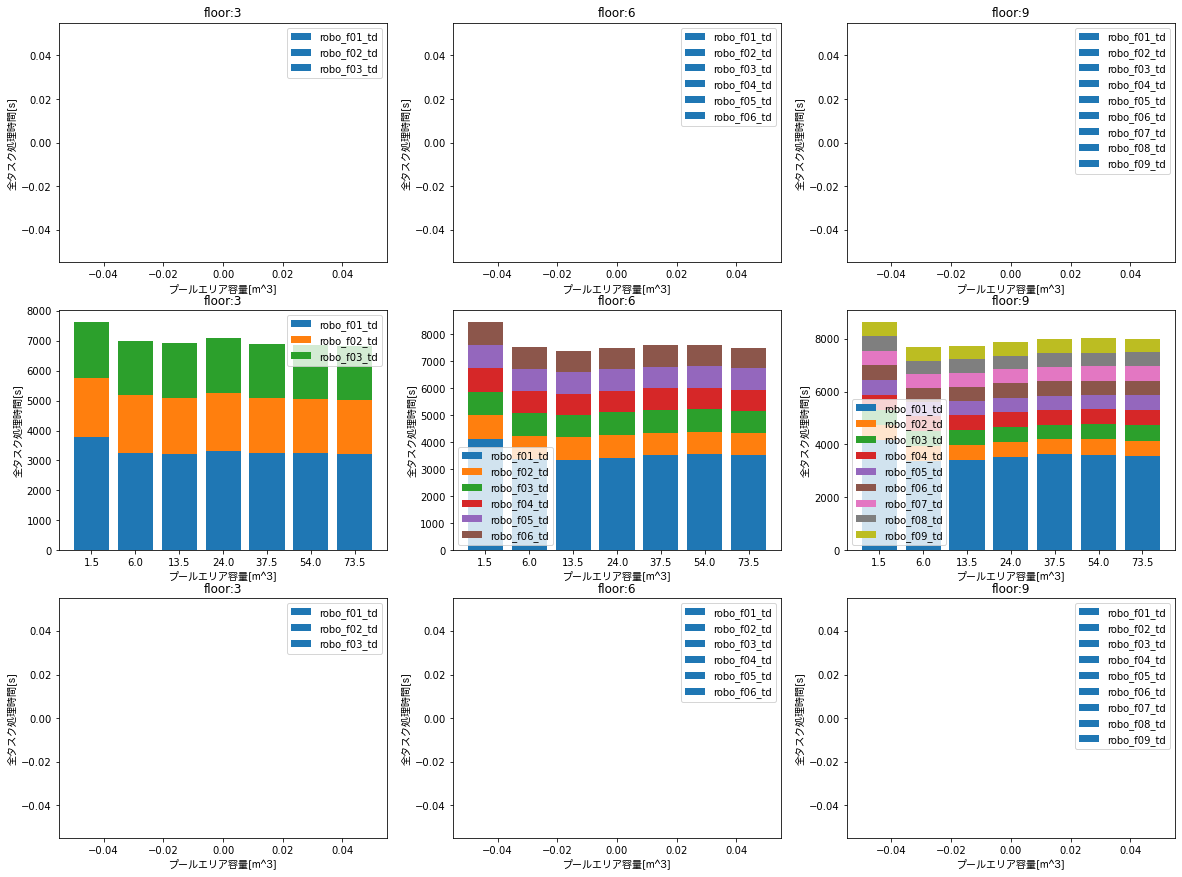

In [91]:
# small_df = df[(df.building=='small_warehouse') & (df.dloc_time==0.0)]
# small_df
# fig = plt.figure(figsize=(20,15))
# for fl in range(3,12,3):
#     #ax = fig.add_subplot(3,3,int(fl//3))
#     for rn in range(1,4):
#         tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))&(small_df['batch']==(small_df['pool_size']*0.8//0.5+1)*0.5)]
#         # print(tmp_df.info())
#         ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        
#         t = tmp_df.groupby(['pool_size']).mean()['comp_time']
#         ax.scatter([str(tmp) for tmp in t.index],t.values, label='robot:{}'.format(rn))
#         ax.legend(loc=0)  
#         ax.set_title('floor:{}'.format(fl))
#         ax.set_xlabel('プールエリア容量[m^3]',fontname="Hiragino Maru Gothic Pro")
#         ax.set_ylabel('全タスク処理時間[s]',fontname="Hiragino Maru Gothic Pro")

small_df
fig = plt.figure(figsize=(20,15))
for fl in range(3,12,3):
    for rn in range(1,4):
        tmp_df = small_df[(small_df['floor']==fl) & (small_df['roboalloc']==str([rn]*fl))]
        #print(tmp_df)
        ax = fig.add_subplot(3,3,int(fl/3+(rn-1)*3))
        #タスク完了時間に対する比率
        t = tmp_df.groupby(['pool_size']).mean()#.div(tmp_df.groupby('pool_size').mean()['comp_time'])
        tr = t.loc[:,'robo_f01_mt':'robo_f0{}_td'.format(fl)]#.div(tmp_df.groupby('pool_size').mean()['comp_time'], axis=0)
        tr  = tr.iloc[:,list(range(3,fl*4,4))]
        tr_t = tr.T
        for i in range(len(tr_t)):
            ax.bar([str(tmp) for tmp in tr_t.columns], tr_t.iloc[i],bottom=tr_t.iloc[:i].sum())
            ax.legend(tr_t.index,loc=0)  
            ax.set_title('floor:{}'.format(fl))
            ax.set_xlabel('プールエリア容量[m^3]',fontname="Hiragino Maru Gothic Pro")
            ax.set_ylabel('全タスク処理時間[s]',fontname="Hiragino Maru Gothic Pro")
            

### large warehouse

## バッチサイズごとの比較

### small warehouse

### タスク完了時間のプロット

../record/small_warehouse_e10/floor03/robonum009/P/pool0016/2022-05-22-9-40.json


Text(0.5, 1.0, 'floor:[3, 6, 9], robo:3')

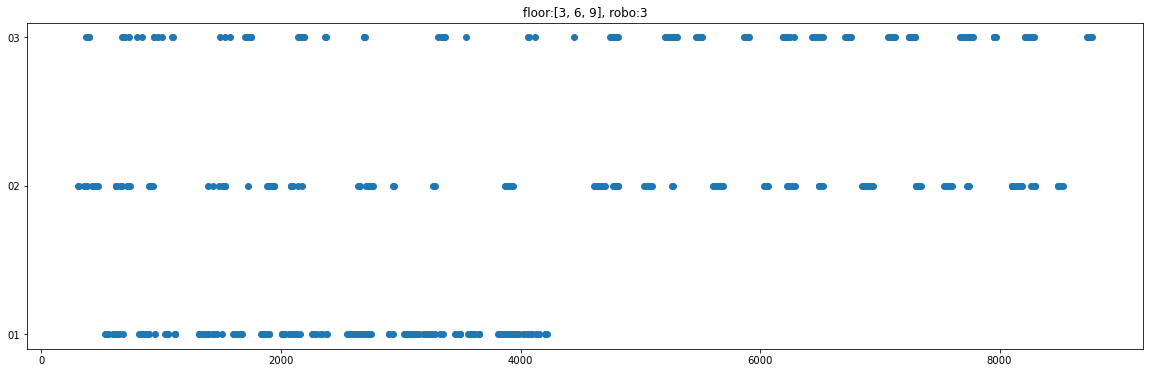

In [95]:

record = {"pickfloor":[], "dfloor":[], "deli_time":[]}
n =0
bldg = ['small_warehouse_e10', 'large_warehouse']
fl = [3, 6, 9]
p = 4
l_path = '../record/{}/floor0{}/robonum0*/P/pool0{}/*.json'.format(bldg[0], fl[0], str(p**2).zfill(3))
# print(glob.glob(l_path))
l_files = natsorted(glob.glob(l_path))
# print(n)
# print(file.split('/')[-1] lambda x: file in l_files)
l_file = l_files[-1]
print(l_file)
# for l_file in l_files:
#     # print(l_file.split('/')[2:])
content = []
with open(l_file) as f:
    content = json.load(f)
    for palet, val in content["task"].items():
        record["pickfloor"].append(val["pickup"][10:12])
        record["dfloor"].append(val["destination"][10:12])
        if "completed_time" in val.keys():
            record["deli_time"].append(val["completed_time"])
        else:
            record["deli_time"].append(None)
rdf = pd.DataFrame(record)
rdf = rdf.sort_values("dfloor")

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
#タスク完了時間に対する比率
ax.scatter([dt for dt in rdf.deli_time],rdf["dfloor"])
ax.set_title('floor:{}, robo:{}'.format(fl, rn))

In [281]:
n =0
for bldg in ['small_warehouse_e1', 'large_warehouse',]:
    for fl in [3, 6, 9]:
        for p in range(1,11):
            l_path = '../record/*/floor0*/robonum0*/P/pool0*/*.json'
            # print(glob.glob(l_path))
            l_files = natsorted(glob.glob(l_path))
            n+=len(l_files)
            # print(n)
            # print(file.split('/')[-1] lambda x: file in l_files)

            for l_file in l_files:
                # print(l_file.split('/')[2:])
                content = []
                with open(l_file) as f:
                    content = json.load(f)
                    dict['building'].append(content['config']['building_type'])
                    dict['floor'].append(fl)
                    dict['pool_size'].append(p**2*1.5)
                    if 'batch'in content['input'].keys():
                        if content['input']['batch']:
                            if content['input']['batch'] > p**2*1.5*0.8:
                                dict['batch'].append((p**2*1.5*0.8//0.5+1)*0.5)
                            else:
                                dict['batch'].append(content['input']['batch'])
                        else:dict['batch'].append(((p**2)*1.5*0.8//0.5+1)*0.5)
                    else:
                        # if p== 8.0:
                        #     print(((p**2)*1.5*0.8//0.5+1)*0.5)
                        dict['batch'].append(((p**2)*1.5*0.8//0.5+1)*0.5)
                    elvsize = content['config']['floor1']['elevator']
                    dict['elv_size'].append(abs((elvsize[0]-elvsize[3])*(elvsize[1]-elvsize[4])))
                    dict['robonum'].append(sum(content['input']['robot_allocation']))
                    dict['roboalloc'].append(str(content['input']['robot_allocation']))
                    dict['comp_time'].append(float(content['output']['complete_time']))
                    if 'deadloc_time' in content['output'].keys():
                        dict['dloc_time'].append(float(content['output']['deadloc_time']))
                    else:
                        dict['dloc_time'].append(0)
                    
                    fl_robo = {}
                    for i in range(1,flnum+1):
                        fl_robo[i] = {}
                        fl_robo[i]['mt'] = []
                        fl_robo[i]['at'] = []
                        fl_robo[i]['st'] = []
                        fl_robo[i]['td'] = []
                    mean_mt = []
                    mean_at = []
                    mean_st = []
                    mean_td = []
                    for robo, info in content['info']['robot'].items():
                        # print(robo, info)
                        fl_robo[int(info['floor'])]['mt'].append(float(info['move_time']))
                        fl_robo[int(info['floor'])]['at'].append(float(info['action_time']))
                        fl_robo[int(info['floor'])]['st'].append(float(info['standby_time']))
                        fl_robo[int(info['floor'])]['td'].append(float(info['travel_distance']))
                        
                    for j in range(1,flnum+1):
                        if fl_robo[j]['mt']:
                            # print(fl_robo[fl]['mt'])
                            dict['robo_f{}_mt'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['mt']) / len(fl_robo[j]['mt']),2 ))    # move time
                            dict['robo_f{}_at'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['at']) / len(fl_robo[j]['at']),2 ))    # action time
                            dict['robo_f{}_st'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['st']) / len(fl_robo[j]['st']),2 ))    # standby time
                            dict['robo_f{}_td'.format(str(j).zfill(2))].append(round(sum(fl_robo[j]['td']) / len(fl_robo[j]['td']),2 ))   # travel distance
                            mean_mt.append(round(sum(fl_robo[j]['mt']) / len(fl_robo[j]['mt']),2 ))
                            mean_at.append(round(sum(fl_robo[j]['at']) / len(fl_robo[j]['at']),2 ))
                            mean_st.append(round(sum(fl_robo[j]['st']) / len(fl_robo[j]['st']),2 ))
                            mean_td.append(round(sum(fl_robo[j]['td']) / len(fl_robo[j]['td']),2 )) 
                        else:
                            dict['robo_f{}_mt'.format(str(j).zfill(2))].append(None)    # move time
                            dict['robo_f{}_at'.format(str(j).zfill(2))].append(None)    # action time
                            dict['robo_f{}_st'.format(str(j).zfill(2))].append(None)    # standby time
                            dict['robo_f{}_td'.format(str(j).zfill(2))].append(None)  # travel distance
                    dict['robo_mean_mt'].append(sum(mean_mt)/len(mean_mt))        # mean move time
                    dict['robo_mean_at'].append(sum(mean_at)/len(mean_at))        # mean action time
                    dict['robo_mean_st'].append(sum(mean_at)/len(mean_st))        # mean standby time
                    dict['robo_mean_td'].append(sum(mean_td)/len(mean_td))        # mean travel distance
                    
                    for elv, info in content['info']['elevator'].items():
                        dict['elv_mt'].append(float(info['move_time']))
                        dict['elv_td'].append(float(info['travel_distance']))
                f.close()
# for k, v in dict.items():
#     print(k, len(v))
# print(dict)
print(n)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
df = pd.DataFrame(dict)
df
df[(df.dloc_time==0.0)&(df.floor==9)&(df.building=='small_warehouse')&(df.batch==59.0)]
# print(df.info())
# print(df[df.dloc_time != 0.0].info())


['../record/large_warehouse/floor02/robonum002/P/pool0001/2022-05-17-1-21.json', '../record/large_warehouse/floor02/robonum002/P/pool0004/2022-05-17-1-22.json', '../record/large_warehouse/floor02/robonum002/P/pool0009/2022-05-17-1-23.json', '../record/large_warehouse/floor02/robonum002/P/pool0016/2022-05-17-1-24.json', '../record/large_warehouse/floor02/robonum002/P/pool0025/2022-05-17-1-25.json', '../record/large_warehouse/floor02/robonum002/P/pool0036/2022-05-17-1-25.json', '../record/large_warehouse/floor02/robonum002/P/pool0049/2022-05-17-1-26.json', '../record/large_warehouse/floor02/robonum002/P/pool0064/2022-05-17-1-27.json', '../record/large_warehouse/floor02/robonum002/P/pool0081/2022-05-17-1-28.json', '../record/large_warehouse/floor02/robonum002/P/pool0100/2022-05-17-1-28.json', '../record/large_warehouse/floor02/robonum004/P/pool0001/2022-05-17-1-30.json', '../record/large_warehouse/floor02/robonum004/P/pool0001/2022-05-17-9-13.json', '../record/large_warehouse/floor02/robo

JSONDecodeError: Expecting ',' delimiter: line 1 column 2145765 (char 2145764)

## 待ち時間割合

/Users/tacky/miniforge3/envs/twinu_alpha/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tacky/miniforge3/envs/twinu_alpha/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


AxisError: axis 1 is out of bounds for array of dimension 1

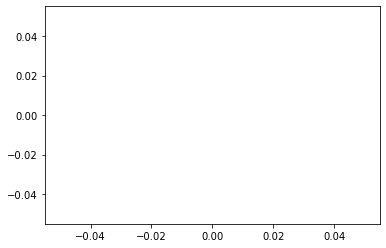

In [339]:



fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_waitRate, axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_waitRate,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('待ち時間割合', fontname="Hiragino Maru Gothic Pro")
plt.title( '待ち時間割合(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

sns.boxplot( 
    data=pd.DataFrame(n_waitRate, index=x).T,
    #patch_artist=True,  
    #widths=0.5,  # boxの幅の設定
    boxprops=dict(facecolor='#1E90FF80',  # boxの塗りつぶし色の設定
                         color='black', linewidth=1)
)
#sns.boxplot( data=pd.DataFrame(e_waitRate, index=x).T)
ratio = np.mean(e_waitRate,axis=1)/np.mean(n_waitRate, axis=1)
print(ratio*100)

# 待ち時間

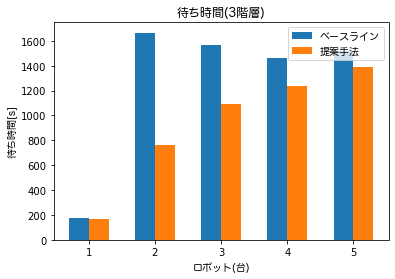

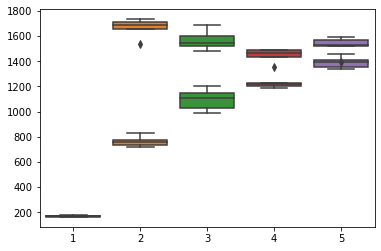

In [89]:
fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_waitTime, axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_waitTime,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('待ち時間[s]', fontname="Hiragino Maru Gothic Pro")
plt.title( '待ち時間(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

sns.boxplot( data=pd.DataFrame(n_waitTime, index=x).T)
sns.boxplot( data=pd.DataFrame(e_waitTime, index=x).T)
ratio = np.mean(e_waitRate,axis=1)/np.mean(n_waitRate, axis=1)

# 余分なカゴ停止時間割合

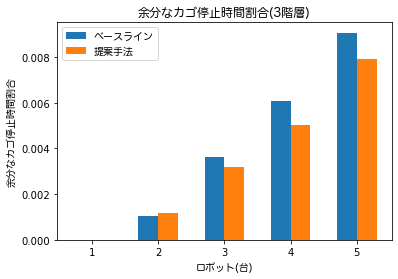

In [90]:
fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_extraStopRate,axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_extraStopRate,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('余分なカゴ停止時間割合', fontname="Hiragino Maru Gothic Pro")
plt.title('余分なカゴ停止時間割合(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

# 余分なカゴ停止時間

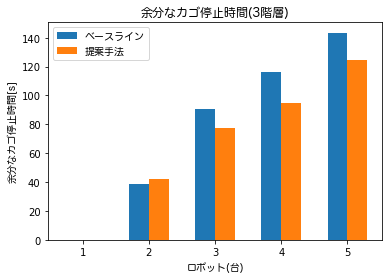

In [91]:
fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_extraStopTime, axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_extraStopTime,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('余分なカゴ停止時間[s]', fontname="Hiragino Maru Gothic Pro")
plt.title('余分なカゴ停止時間(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

# タスク処理時間

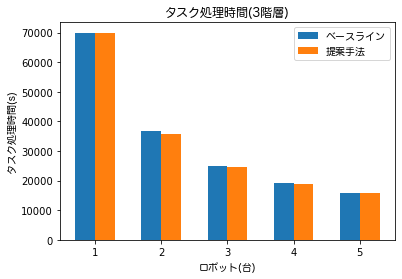

[99.99202498 96.88924847 97.54764428 98.59845589 99.61450817]


In [92]:
fig, ax = plt.subplots(facecolor="w")
plt.bar(x, np.mean(n_processingTime,axis=1), width=-0.3, align="edge", label='ベースライン')
plt.bar(x, np.mean(e_processingTime,axis=1), width=0.3, align="edge", label='提案手法')
# ax.bar(x, n_extraStopTime, label='extraStopTime')
# ax.bar(x, n_waitTime, label='waitTime')
# ax.bar(x, n_waitTime, label='waitTime')
plt.xlabel('ロボット(台)', fontname="Hiragino Maru Gothic Pro")
plt.ylabel('タスク処理時間(s)', fontname="Hiragino Maru Gothic Pro")
plt.title('タスク処理時間(3階層)', fontname="Hiragino Maru Gothic Pro")
plt.legend(prop={"family":"Hiragino Maru Gothic Pro"})
plt.show()

ratio = np.mean(e_processingTime,axis=1)/np.mean(n_processingTime, axis=1)
print(ratio*100)